# DoE - Validation of dimensioning of Battery system
The purpose of this notebook is to show you an example of how to apply the DoE technique related to validation of dimensioning of the Home Energy Management System example.

In Denmark, any surplus in energy production from PVs and/or WTs can be returned to the grid, but with no monetary gain for the prosumer. That is, Ørsted will not pay you for the extra electricity that you send back to the grid. Thus, it becomes advantageous for the prosumer to store this surplus in energy for later, say, when the Sun has gone down.

That's a common HEMS scenario, which can be sketched like this:
<img src="graphics/battery_use_case.svg" width="800">

The purpose of this scenario is to **replicate** a test in order to understand if the sizing of a battery is correct over a series of days.

In [1]:
import pandas as pd
import HEMS_sim
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# Dictionary with basic configuration of the simulation
''' The Dictionary must contain base values for the following variables
ID: is the id for the specific recipe.
batt_storage_capacity is the storage size of the battery in kWh.
batt_charge_capacity is the charge/discharge rate of the battery in kW.
pv1_scaling is the scaling of the PV production. 1 corresponds to a maximum capacity of about 5 kW.
controller_change_rate is smoothing variable for the controller.
climate_conditions can be "sunny", "intermittent", or "cloudy".
random_weather determines if the climate_conditions are random days. Is a boolean, True or False.
season scales the consumption. Can be "summer", "autumn", "winter", or "spring".
stochastic determines if it's a stochastic or deterministic simulation. Boolean, True (sctochastic) or False (deterministic).
noise_scale scales the noise that the stochastic simulation adds.
'''

basic_conf = {
    'ID':'00',
    'batt_storage_capacity':20,
    'batt_charge_capacity':5,
    'pv1_scaling':1,
    'controller_change_rate':0.5,
    'climate_conditions':'sunny',
    'random_weather':False,
    'season':'autumn',
    'stochastic':True,
    'noise_scale':1}

In [3]:
# Scenario name which determines the name of the files we will be saving with the results
scenario_name = 'test_1'

# Dictionary with the variations we want to introduce
variations = {'run_01': {'ID':'01','batt_storage_capacity':15,'controller_change_rate':0.3},
              'run_02': {'ID':'02','batt_storage_capacity':15,'controller_change_rate':0.7},
              'run_03': {'ID':'03','batt_storage_capacity':25,'controller_change_rate':0.3},
              'run_04': {'ID':'04','batt_storage_capacity':25,'controller_change_rate':0.7}}

# Merging of the basic configuration and the variations
recipes = {key: basic_conf.copy() for key in variations}
recipes = {key: {**recipes[key],**data} for key,data in variations.items()}


## Running and plotting the simulations

The two code blocks below run the simulations, one for each scenario defined in the variations dictionary defined above. This may take some time, depending on the amount of scenarios and how fast your computer is.

In [4]:
for recipe in recipes:
    HEMS_sim.run_simulation(scenario_name,recipes[recipe])

Starting "DemandModel" as "DemandModel-0" ...
Starting "SimpleGridModel" as "SimpleGridModel-0" ...
Starting "CollectorSim" as "CollectorSim-0" ...
Starting "PVModel" as "PVModel-0" ...
Starting "BatteryModel" as "BatteryModel-0" ...
Starting "Control" as "Control-0" ...
Starting "NoiseGenerator" as "NoiseGenerator-0" ...
Starting simulation.


Simulation finished successfully.
Saved to store: temp_files/test_1_data.h5, dataframe: timeseries/sim_01
   ID  Energy bill [DKK/kWh]  Max. in-feed [kW]  Energy Imported [kWh]  \
0  01               3.482955           5.094311               8.930653   

   Energy exported [kWh]  Self consumption index  pv1_capacity [kW]  \
0             -11.681065                0.703575                  1   

   battery storage capacity [kWh]  battery charge capacity[kW]  \
0                              15                            5   

  climate_conditions  controller_change_rate         File ID/dataframe  
0              sunny                     0.3  test_1/timeseries/sim_01  
Starting "DemandModel" as "DemandModel-0" ...
Starting "SimpleGridModel" as "SimpleGridModel-0" ...
Starting "CollectorSim" as "CollectorSim-0" ...
Starting "PVModel" as "PVModel-0" ...
Starting "BatteryModel" as "BatteryModel-0" ...
Starting "Control" as "Control-0" ...
Starting "NoiseGenerator" as "NoiseGenerator-0" ...

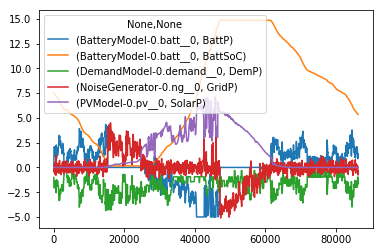

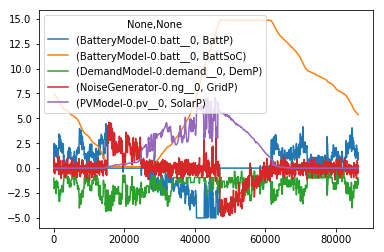

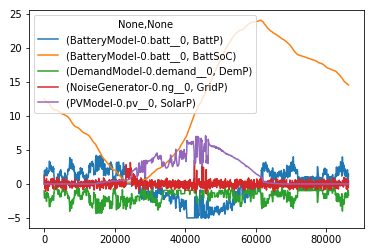

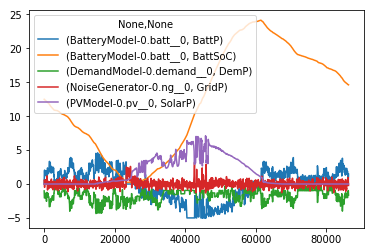

In [5]:
store = pd.HDFStore('temp_files/{}_data.h5'.format(scenario_name))
#print(store.keys())
df_1 = store[store.keys()[0]]
df_2 = store[store.keys()[1]]
df_3 = store[store.keys()[2]]
df_4 = store[store.keys()[3]]
store.close()

df_1.plot()
df_2.plot()
df_3.plot()
df_4.plot()

## Summary statistics
The cells below show some summary statistics, as well as two examples of histogram plots of two summary statistics.

The *Self-consumption index* is defined as:
$$SCI = \frac{\textrm{Total PV generation} - \textrm{Total exported energy}}{\textrm{Total PV generation}}$$

In this and the following assays, we will try to examine which factors influence the self-consumption index.

In [6]:
run_store = pd.HDFStore('temp_files/runs_summary_{}.h5'.format(scenario_name))
run_store.keys()

summary_1 = run_store[run_store.keys()[0]]
summary_2 = run_store[run_store.keys()[1]]
summary_3 = run_store[run_store.keys()[2]]
summary_4 = run_store[run_store.keys()[3]]
summaries = pd.concat([summary_1,summary_2,summary_3,summary_4])
summaries

,ID,Energy bill [DKK/kWh],Max. in-feed [kW],Energy Imported [kWh],Energy exported [kWh],Self consumption index,pv1_capacity [kW],battery storage capacity [kWh],battery charge capacity[kW],climate_conditions,controller_change_rate,File ID/dataframe
0,01,3.482955,5.094311,8.930653,-11.681065,0.703575,1,15,5,sunny,0.3,test_1/timeseries/sim_01
0,02,3.586228,4.860991,9.195457,-12.180391,0.690904,1,15,5,sunny,0.7,test_1/timeseries/sim_02
0,03,1.909269,3.508066,4.895561,-3.808015,0.903366,1,25,5,sunny,0.3,test_1/timeseries/sim_03
0,04,2.030222,3.202390,5.205696,-4.133855,0.895097,1,25,5,sunny,0.7,test_1/timeseries/sim_04


(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([4.89556113, 5.32555074, 5.75554034, 6.18552995, 6.61551955,
        7.04550916, 7.47549876, 7.90548837, 8.33547797, 8.76546758,
        9.19545718]),
 <a list of 10 Patch objects>)

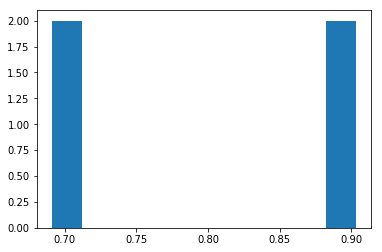

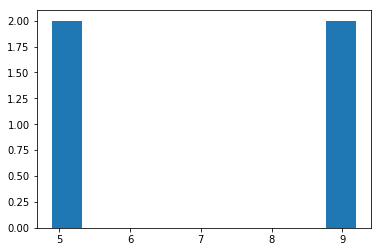

In [7]:
plt.figure()
plt.hist(summaries['Self consumption index'])
plt.figure()
plt.hist(summaries['Energy Imported [kWh]'])